In [2]:
#!pip install HASS-data-detective # Install detective

In [3]:
!pip show HASS-data-detective

Name: HASS-data-detective
Version: 3.0
Summary: Tools for studying Home Assistant data.
Home-page: https://github.com/robmarkcole/HASS-data-detective
Author: Robin Cole
Author-email: robmarkcole@gmail.com
License: MIT
Location: /usr/local/lib/python3.11/dist-packages
Requires: pandas, pytz, ruamel.yaml, SQLAlchemy
Required-by: 


In [4]:
import detective.core as detective
import detective.functions as functions
import pandas as pd
import sqlalchemy
from typing import Optional, Union

db = detective.db_from_hass_config()

YAML tag !include_dir_merge_named is not supported
Successfully connected to database sqlite:////config/home-assistant_v2.db
There are 512 entities with data


In [5]:
# dir(db)

In [6]:
df = db.fetch_all_sensor_data()


            SELECT states.state, states.last_updated_ts, states_meta.entity_id
            FROM states
            JOIN states_meta
            ON states.metadata_id = states_meta.metadata_id
            WHERE
                states_meta.entity_id  LIKE '%sensor%'
            AND
                states.state NOT IN ('unknown', 'unavailable')
            ORDER BY last_updated_ts DESC
        LIMIT 50000
The returned Pandas dataframe has 50000 rows of data.


In [7]:
# db.entities

In [8]:

# df = db.fetch_all_data_of([
#     # 'sensor.total_energy_export',
#     'weather.forecast_home'
# ], 
#                          # get_attributes=True
#                          )
# df

# První a poslední záznamy

In [9]:
query=f"""
    SELECT entity_id, last_updated_ts
    FROM states
    ORDER BY last_updated_ts DESC
    LIMIT 3
"""
query = sqlalchemy.text(query)
df = pd.read_sql_query(query, con=db.con)
df['last_updated_ts'] = pd.to_datetime(df['last_updated_ts'], unit='s')

df

,entity_id,last_updated_ts
0,None,2024-11-24 15:39:39.250954390
1,None,2024-11-24 15:39:38.879202843
2,None,2024-11-24 15:39:38.661136389


In [10]:
query=f"""
    SELECT entity_id, last_updated_ts
    FROM states
    ORDER BY last_updated_ts
    LIMIT 3
"""
query = sqlalchemy.text(query)
df = pd.read_sql_query(query, con=db.con)
df['last_updated_ts'] = pd.to_datetime(df['last_updated_ts'], unit='s')

df

,entity_id,last_updated_ts
0,None,2024-11-14 03:12:00.954989195
1,None,2024-11-14 03:12:00.995421648
2,None,2024-11-14 03:12:02.922845840


In [11]:
query=f"""
    SELECT *
    FROM statistics
    LIMIT 3
"""
query = sqlalchemy.text(query)
df = pd.read_sql_query(query, con=db.con)
# df['last_updated_ts'] = pd.to_datetime(df['start_ts'], unit='s')

df

,id,created,created_ts,metadata_id,start,start_ts,mean,min,max,last_reset,last_reset_ts,state,sum
0,1,None,1.690783e+09,1,None,1.690780e+09,209.161491,200.9,217.1,None,None,None,None
1,2,None,1.690783e+09,2,None,1.690780e+09,4.051528,1.7,8.9,None,None,None,None
2,3,None,1.690783e+09,3,None,1.690780e+09,854.633293,344.0,1924.0,None,None,None,None


In [12]:
query=f"""
    SELECT *
    FROM statistics_meta
    LIMIT 3
"""
query = sqlalchemy.text(query)
df = pd.read_sql_query(query, con=db.con)
# df['last_updated_ts'] = pd.to_datetime(df['start_ts'], unit='s')

df

,id,statistic_id,source,unit_of_measurement,has_mean,has_sum,name
0,1,sensor.pv1_voltage,recorder,V,1,0,None
1,2,sensor.pv1_current,recorder,A,1,0,None
2,3,sensor.pv1_power,recorder,W,1,0,None


In [13]:
import sqlalchemy
from sqlalchemy import create_engine, text
from typing import Tuple
import json

def fetch_all_data_of(self, sensors: Union[None,Tuple[str],str]=None, limit=50000, get_attributes=False, parse_attributes=True, 
                      print_query=False, use_statistics=False, desc:bool=True,
                      filter_empty:bool=True
                     ) -> pd.DataFrame:
    if sensors is None:
        query_where_selection=""
    else:
        if type(sensors) == str:
            sensors=[sensors]
        sensors_str = str(tuple(sensors))
        if len(sensors) == 1:
            sensors_str = sensors_str.replace(",", "")
        print(sensors_str)
        
        query_filter = \
        f"""
        AND
            state NOT IN ('unknown', 'unavailable')
        """
        query_filter = query_filter if filter_empty else ""
        query_where_selection = \
            f"""
            WHERE 
                entity_id IN {sensors_str}
            {query_filter}
            """

    print(query_where_selection)
    query_no_attr = f"""
        WITH combined_states AS (
            SELECT states.state, states.last_updated_ts, states_meta.entity_id
            FROM states
            JOIN states_meta
            ON states.metadata_id = states_meta.metadata_id
        )
        SELECT *
        {query_where_selection}
        ORDER BY last_updated_ts DESC
    """

    query_attr = f"""
        WITH combined_states AS (
            SELECT states.state, states.last_updated_ts, states_meta.entity_id, state_attributes.shared_attrs AS attributes
            FROM states
            JOIN states_meta
            ON states.metadata_id = states_meta.metadata_id
            LEFT JOIN state_attributes
            ON states.attributes_id = state_attributes.attributes_id
        )
        SELECT *
        FROM combined_states
        {query_where_selection}
        ORDER BY last_updated_ts DESC
    """
    query_statistics = f"""
        WITH combined_states AS (
            SELECT statistics.start_ts as last_updated_ts, statistics_meta.statistic_id as entity_id, *
            FROM statistics
            JOIN statistics_meta
            ON statistics.metadata_id = statistics_meta.id
        )
        SELECT *
        FROM combined_states
        {query_where_selection}
        ORDER BY last_updated_ts
    """

        # WHERE 
        #     entity_id IN {sensors_str}
        # AND
        #     state NOT IN ('unknown', 'unavailable')
    
    
    if use_statistics:
        query = query_statistics
    else:
        query = query_attr if get_attributes else query_no_attr

    if desc:
        query += " DESC "
    if limit is not None:
        query += f" LIMIT {limit}"
    if print_query:
        print(query)
    query = text(query)
    df = pd.read_sql_query(query, con=self.con)

       # Parse attributes if they exist
    if parse_attributes:
        if 'attributes' in df.columns:
            df['parsed_attributes'] = df['attributes'].apply(lambda x: json.loads(x) if pd.notnull(x) else {})
            
    df['last_updated_datetime'] = pd.to_datetime(df['last_updated_ts'], unit='s')

    return df


# Get historical data stored in `statistics` table



In [19]:
df = fetch_all_data_of(db, use_statistics=True, filter_empty=False)
df.statistic_id.unique()

array(['sensor.system_monitor_volno_na_disku',
       'sensor.system_monitor_teplota_procesoru',
       'sensor.speedtest_nahravani', 'sensor.speedtest_stahovani',
       'sensor.speedtest_ping', 'sensor.sm_t510_battery_level',
       'sensor.spot_price_numeric_status',
       'sensor.roomba_neuspesne_uklidy', 'sensor.roomba_zrusene_uklidy',
       'sensor.roomba_uspesne_uklidy', 'sensor.roomba_celkem_uklidu',
       'sensor.energy_sell_daily_compensation',
       'sensor.energy_buy_daily_cost', 'sensor.forecast_temperature',
       'sensor.house_consumption_daily', 'sensor.house_consumption_sum',
       'sensor.energy_sell_sum', 'sensor.energy_buy_sum',
       'sensor.192_168_1_138_rychlost_nahravani',
       'sensor.192_168_1_138_rychlost_stahovani',
       'sensor.teplomer_vymenik_tuv_battery', 'sensor.vrata_battery',
       'sensor.teplomer_vymenik_tuv_humidity',
       'sensor.teplomer_vymenik_tuv_temperature',
       'sensor.teplomer_tuv_humidity', 'sensor.teplomer_tuv_temperatur

In [21]:
[entity_id for entity_id in df.statistic_id.unique() if "temperature" in entity_id]

['sensor.forecast_temperature',
 'sensor.teplomer_vymenik_tuv_temperature',
 'sensor.teplomer_tuv_temperature',
 'sensor.teplomer_venku_temperature',
 'sensor.teplomer_obyvak_temperature',
 'sensor.teplomer_sklenik_temperature',
 'sensor.battery_min_cell_temperature',
 'sensor.battery_max_cell_temperature',
 'sensor.battery_min_cell_temperature_id',
 'sensor.battery_max_cell_temperature_id',
 'sensor.battery_temperature',
 'sensor.inverter_temperature_radiator',
 'sensor.inverter_temperature_module',
 'sensor.inverter_temperature_air']

In [54]:
entity_id = 'sensor.total_energy_export'
entity_id = 'sensor.total_energy_import'
# entity_id = 'sensor.total_pv_generation'
entity_id = "sensor.pv1_voltage"
entity_id = "sensor.total_energy_export"
entity_id = "sensor.house_consumption"
entity_id = "sensor.house_consumption_daily"

In [55]:
df = fetch_all_data_of(db, 
    # 'sensor.meter_total_energy_export',
       entity_id,
                       # "sensor.pv1_voltage",

                       use_statistics=True,
                       desc=False,
                       filter_empty=False
                      )
df

('sensor.house_consumption_daily')

            WHERE 
                entity_id IN ('sensor.house_consumption_daily')
            
            


,last_updated_ts,entity_id,id,created,created_ts,metadata_id,start,start_ts,mean,min,...,state,sum,id:1,statistic_id,source,unit_of_measurement,has_mean,has_sum,name,last_updated_datetime
0,1.728799e+09,sensor.house_consumption_daily,1270442,None,1.728803e+09,222,None,1.728799e+09,None,None,...,1.3,1.3,222,sensor.house_consumption_daily,recorder,kWh,0,1,None,2024-10-13 06:00:00
1,1.728803e+09,sensor.house_consumption_daily,1270614,None,1.728806e+09,222,None,1.728803e+09,None,None,...,3.4,3.4,222,sensor.house_consumption_daily,recorder,kWh,0,1,None,2024-10-13 07:00:00
2,1.728806e+09,sensor.house_consumption_daily,1270786,None,1.728810e+09,222,None,1.728806e+09,None,None,...,5.9,5.9,222,sensor.house_consumption_daily,recorder,kWh,0,1,None,2024-10-13 08:00:00
3,1.728810e+09,sensor.house_consumption_daily,1270958,None,1.728814e+09,222,None,1.728810e+09,None,None,...,8.3,8.3,222,sensor.house_consumption_daily,recorder,kWh,0,1,None,2024-10-13 09:00:00
4,1.728814e+09,sensor.house_consumption_daily,1271130,None,1.728817e+09,222,None,1.728814e+09,None,None,...,11.0,11.0,222,sensor.house_consumption_daily,recorder,kWh,0,1,None,2024-10-13 10:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1010,1.732457e+09,sensor.house_consumption_daily,1454753,None,1.732460e+09,222,None,1.732457e+09,None,None,...,39.9,2365.6,222,sensor.house_consumption_daily,recorder,kWh,0,1,None,2024-11-24 14:00:00
1011,1.732460e+09,sensor.house_consumption_daily,1454946,None,1.732464e+09,222,None,1.732460e+09,None,None,...,42.3,2368.0,222,sensor.house_consumption_daily,recorder,kWh,0,1,None,2024-11-24 15:00:00
1012,1.732464e+09,sensor.house_consumption_daily,1455137,None,1.732468e+09,222,None,1.732464e+09,None,None,...,45.6,2371.3,222,sensor.house_consumption_daily,recorder,kWh,0,1,None,2024-11-24 16:00:00
1013,1.732468e+09,sensor.house_consumption_daily,1455328,None,1.732471e+09,222,None,1.732468e+09,None,None,...,49.8,2375.5,222,sensor.house_consumption_daily,recorder,kWh,0,1,None,2024-11-24 17:00:00


## round date time to whole hours

In [56]:
def round_ts(df, column='state'):
    df['last_updated_ts'] = pd.to_datetime(df['last_updated_ts'], unit='s')
    df['last_updated_ts'] = df['last_updated_ts'].dt.floor('h')
    # df = df.groupby('last_updated_ts').agg({column:'mean'}).reset_index()
    df = df.groupby('last_updated_ts').first().reset_index()
    return df




In [57]:
df = round_ts(df)
print(df.keys())
df

Index(['last_updated_ts', 'entity_id', 'id', 'created', 'created_ts',
       'metadata_id', 'start', 'start_ts', 'mean', 'min', 'max', 'last_reset',
       'last_reset_ts', 'state', 'sum', 'id:1', 'statistic_id', 'source',
       'unit_of_measurement', 'has_mean', 'has_sum', 'name',
       'last_updated_datetime'],
      dtype='object')


,last_updated_ts,entity_id,id,created,created_ts,metadata_id,start,start_ts,mean,min,...,state,sum,id:1,statistic_id,source,unit_of_measurement,has_mean,has_sum,name,last_updated_datetime
0,2024-10-13 06:00:00,sensor.house_consumption_daily,1270442,None,1.728803e+09,222,None,1.728799e+09,None,None,...,1.3,1.3,222,sensor.house_consumption_daily,recorder,kWh,0,1,None,2024-10-13 06:00:00
1,2024-10-13 07:00:00,sensor.house_consumption_daily,1270614,None,1.728806e+09,222,None,1.728803e+09,None,None,...,3.4,3.4,222,sensor.house_consumption_daily,recorder,kWh,0,1,None,2024-10-13 07:00:00
2,2024-10-13 08:00:00,sensor.house_consumption_daily,1270786,None,1.728810e+09,222,None,1.728806e+09,None,None,...,5.9,5.9,222,sensor.house_consumption_daily,recorder,kWh,0,1,None,2024-10-13 08:00:00
3,2024-10-13 09:00:00,sensor.house_consumption_daily,1270958,None,1.728814e+09,222,None,1.728810e+09,None,None,...,8.3,8.3,222,sensor.house_consumption_daily,recorder,kWh,0,1,None,2024-10-13 09:00:00
4,2024-10-13 10:00:00,sensor.house_consumption_daily,1271130,None,1.728817e+09,222,None,1.728814e+09,None,None,...,11.0,11.0,222,sensor.house_consumption_daily,recorder,kWh,0,1,None,2024-10-13 10:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1010,2024-11-24 14:00:00,sensor.house_consumption_daily,1454753,None,1.732460e+09,222,None,1.732457e+09,None,None,...,39.9,2365.6,222,sensor.house_consumption_daily,recorder,kWh,0,1,None,2024-11-24 14:00:00
1011,2024-11-24 15:00:00,sensor.house_consumption_daily,1454946,None,1.732464e+09,222,None,1.732460e+09,None,None,...,42.3,2368.0,222,sensor.house_consumption_daily,recorder,kWh,0,1,None,2024-11-24 15:00:00
1012,2024-11-24 16:00:00,sensor.house_consumption_daily,1455137,None,1.732468e+09,222,None,1.732464e+09,None,None,...,45.6,2371.3,222,sensor.house_consumption_daily,recorder,kWh,0,1,None,2024-11-24 16:00:00
1013,2024-11-24 17:00:00,sensor.house_consumption_daily,1455328,None,1.732471e+09,222,None,1.732468e+09,None,None,...,49.8,2375.5,222,sensor.house_consumption_daily,recorder,kWh,0,1,None,2024-11-24 17:00:00


In [58]:
df.has_mean.unique()

array([0])

In [62]:
def prepare_entity_data_hourly(entity_id):
    df = fetch_all_data_of(db, entity_id, use_statistics=True, filter_empty=False)
    df = round_ts(df)
    has_mean_unique = df.has_mean.unique()
    assert len(has_mean_unique) == 1, f"Some data has mean and some not. {has_mean_unique=}"
    if has_mean_unique[0] == 1:
        df[entity_id] = df["mean"]
    else:
        df[entity_id] = df["state"]
    # if df.has_mean:
    # df.loc[entity_id, df.has_mean==1] = df.loc["mean", df.has_mean==1]
    df = df[["last_updated_datetime", entity_id]]
    df.reset_index()
    return df

In [63]:
prepare_entity_data_hourly(entity_id)

('sensor.house_consumption_daily')

            WHERE 
                entity_id IN ('sensor.house_consumption_daily')
            
            


,last_updated_datetime,sensor.house_consumption_daily
0,2024-10-13 06:00:00,1.3
1,2024-10-13 07:00:00,3.4
2,2024-10-13 08:00:00,5.9
3,2024-10-13 09:00:00,8.3
4,2024-10-13 10:00:00,11.0
...,...,...
1010,2024-11-24 14:00:00,39.9
1011,2024-11-24 15:00:00,42.3
1012,2024-11-24 16:00:00,45.6
1013,2024-11-24 17:00:00,49.8


# merge data together

In [73]:
from typing import List
import pandas as pd

def merge_dataframes(df_list: List[pd.DataFrame], key: str, how: str = "outer") -> pd.DataFrame:
    """
    Merges a list of DataFrames on a specified key column.
    
    Parameters:
    - df_list: List of pandas DataFrames to merge.
    - key: The column name to merge on.
    - how: Type of merge to perform ('outer', 'inner', 'left', 'right'). Default is 'outer'.
    
    Returns:
    - A single DataFrame merged on the specified key.
    """
    if not df_list:
        raise ValueError("The list of DataFrames is empty.")
    
    # Start with the first DataFrame
    merged_df = df_list[0]
    
    # Merge each subsequent DataFrame
    for df in df_list[1:]:
        merged_df = merged_df.merge(df, on=key, how=how)
    
    # Optional: Sort by the key column if it's datetime
    if pd.api.types.is_datetime64_any_dtype(merged_df[key]):
        merged_df = merged_df.sort_values(by=key).reset_index(drop=True)
    
    return merged_df


def prepare_history_data(entity_ids:List, how:str="outer") -> pd.DataFrame:
    dfs =[prepare_entity_data_hourly(entity_id) for entity_id in entity_ids]

    return merge_dataframes(dfs, key="last_updated_datetime", how=how)

    

In [74]:
prepare_entity_data_hourly("sensor.forecast_temperature")

('sensor.forecast_temperature')

            WHERE 
                entity_id IN ('sensor.forecast_temperature')
            
            


,last_updated_datetime,sensor.forecast_temperature
0,2024-10-20 12:00:00,15.300000
1,2024-10-20 13:00:00,15.960673
2,2024-10-20 14:00:00,16.107738
3,2024-10-20 15:00:00,15.755480
4,2024-10-20 16:00:00,14.687518
...,...,...
835,2024-11-24 15:00:00,11.053594
836,2024-11-24 16:00:00,10.818492
837,2024-11-24 17:00:00,10.984840
838,2024-11-24 18:00:00,10.905913


In [75]:
prepare_entity_data_hourly("sensor.teplomer_venku_temperature")

('sensor.teplomer_venku_temperature')

            WHERE 
                entity_id IN ('sensor.teplomer_venku_temperature')
            
            


,last_updated_datetime,sensor.teplomer_venku_temperature
0,2023-09-07 13:00:00,24.210460
1,2023-09-07 14:00:00,23.063239
2,2023-09-07 15:00:00,23.003722
3,2023-09-07 16:00:00,23.065629
4,2023-09-07 17:00:00,22.906603
...,...,...
6359,2024-11-24 15:00:00,12.399501
6360,2024-11-24 16:00:00,11.376284
6361,2024-11-24 17:00:00,10.887013
6362,2024-11-24 18:00:00,10.264910


In [78]:
df = prepare_history_data(["sensor.forecast_temperature", "sensor.house_consumption_daily", "sensor.teplomer_venku_temperature"], how="inner")
df

('sensor.forecast_temperature')

            WHERE 
                entity_id IN ('sensor.forecast_temperature')
            
            
('sensor.house_consumption_daily')

            WHERE 
                entity_id IN ('sensor.house_consumption_daily')
            
            
('sensor.teplomer_venku_temperature')

            WHERE 
                entity_id IN ('sensor.teplomer_venku_temperature')
            
            


,last_updated_datetime,sensor.forecast_temperature,sensor.house_consumption_daily,sensor.teplomer_venku_temperature
0,2024-10-20 12:00:00,15.300000,30.1,24.631915
1,2024-10-20 13:00:00,15.960673,33.0,24.655556
2,2024-10-20 14:00:00,16.107738,34.6,24.517610
3,2024-10-20 15:00:00,15.755480,36.9,24.447572
4,2024-10-20 16:00:00,14.687518,39.0,24.607072
...,...,...,...,...
831,2024-11-24 15:00:00,11.053594,42.3,12.399501
832,2024-11-24 16:00:00,10.818492,45.6,11.376284
833,2024-11-24 17:00:00,10.984840,49.8,10.887013
834,2024-11-24 18:00:00,10.905913,53.1,10.264910


In [82]:
# datetime as string
import datetime
dt_str = datetime.datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
df.to_csv(f"homeassistant_export.{dt_str}.csv")

<Axes: xlabel='last_updated_datetime', ylabel='sensor.forecast_temperature'>

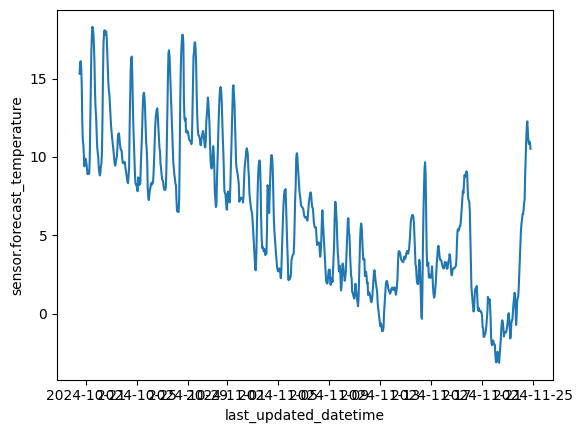

In [81]:
import seaborn as sns
sns.lineplot(data=df, x="last_updated_datetime", y="sensor.forecast_temperature")

In [16]:
sorted(df["entity_id"].unique())

['sensor.active_power',
 'sensor.active_power_l1',
 'sensor.active_power_l2',
 'sensor.active_power_l3',
 'sensor.active_power_total',
 'sensor.back_up_l1_current',
 'sensor.back_up_l1_frequency',
 'sensor.back_up_l1_power',
 'sensor.back_up_l1_voltage',
 'sensor.back_up_l2_current',
 'sensor.back_up_l2_frequency',
 'sensor.back_up_l2_power',
 'sensor.back_up_l2_voltage',
 'sensor.back_up_l3_current',
 'sensor.back_up_l3_frequency',
 'sensor.back_up_l3_power',
 'sensor.back_up_l3_voltage',
 'sensor.back_up_load',
 'sensor.battery_bms',
 'sensor.battery_charge_limit',
 'sensor.battery_current',
 'sensor.battery_discharge_limit',
 'sensor.battery_error_h',
 'sensor.battery_error_l',
 'sensor.battery_hardware_version',
 'sensor.battery_index',
 'sensor.battery_max_cell_temperature',
 'sensor.battery_max_cell_temperature_id',
 'sensor.battery_max_cell_voltage',
 'sensor.battery_max_cell_voltage_id',
 'sensor.battery_min_cell_temperature',
 'sensor.battery_min_cell_temperature_id',
 'sensor

In [ ]:
[entity_id

# Weather prediction temperture

It is not useful, because the data are purged after 10 days

In [41]:

df = fetch_all_data_of(db, [
    # 'sensor.meter_total_energy_export',
    'weather.forecast_home'
], 
                       # get_attributes=False, parse_attributes=False
                       get_attributes=True, parse_attributes=True
                      )
df

,state,last_updated_ts,entity_id,attributes,parsed_attributes,last_updated_datetime
0,partlycloudy,1.732291e+09,weather.forecast_home,"{""temperature"":-0.8,""dew_point"":-5.4,""temperat...","{'temperature': -0.8, 'dew_point': -5.4, 'temp...",2024-11-22 15:51:42.899602175
1,cloudy,1.732287e+09,weather.forecast_home,"{""temperature"":-0.5,""dew_point"":-5.9,""temperat...","{'temperature': -0.5, 'dew_point': -5.9, 'temp...",2024-11-22 14:52:40.875569820
2,cloudy,1.732284e+09,weather.forecast_home,"{""temperature"":-0.4,""dew_point"":-5.8,""temperat...","{'temperature': -0.4, 'dew_point': -5.8, 'temp...",2024-11-22 13:53:40.923120499
3,partlycloudy,1.732280e+09,weather.forecast_home,"{""temperature"":-0.6,""dew_point"":-5.6,""temperat...","{'temperature': -0.6, 'dew_point': -5.6, 'temp...",2024-11-22 12:54:38.860282660
4,partlycloudy,1.732277e+09,weather.forecast_home,"{""temperature"":-1.1,""dew_point"":-5.2,""temperat...","{'temperature': -1.1, 'dew_point': -5.2, 'temp...",2024-11-22 11:55:38.858000994
...,...,...,...,...,...,...
253,cloudy,1.731397e+09,weather.forecast_home,"{""temperature"":0.7,""dew_point"":-0.0,""temperatu...","{'temperature': 0.7, 'dew_point': -0.0, 'tempe...",2024-11-12 07:36:43.659861565
254,fog,1.731394e+09,weather.forecast_home,"{""temperature"":0.9,""dew_point"":0.3,""temperatur...","{'temperature': 0.9, 'dew_point': 0.3, 'temper...",2024-11-12 06:38:43.675766230
255,fog,1.731390e+09,weather.forecast_home,"{""temperature"":1.2,""dew_point"":0.3,""temperatur...","{'temperature': 1.2, 'dew_point': 0.3, 'temper...",2024-11-12 05:40:43.681876183
256,fog,1.731387e+09,weather.forecast_home,"{""temperature"":1.3,""dew_point"":0.3,""temperatur...","{'temperature': 1.3, 'dew_point': 0.3, 'temper...",2024-11-12 04:42:36.674832344


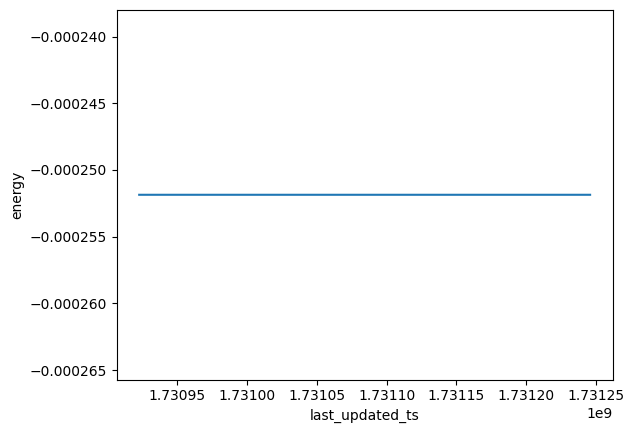

In [83]:
sns.lineplot(data=df, x='last_updated_ts', y='energy')
plt.show()

In [61]:
round_ts(df)

,state,last_updated_ts,entity_id
0,655,2024-11-09 22:00:00,sensor.house_consumption
1,511,2024-11-09 22:00:00,sensor.house_consumption
2,506,2024-11-09 22:00:00,sensor.house_consumption
3,499,2024-11-09 22:00:00,sensor.house_consumption
4,506,2024-11-09 22:00:00,sensor.house_consumption
...,...,...,...
49995,6129,2024-11-06 03:00:00,sensor.house_consumption
49996,6159,2024-11-06 03:00:00,sensor.house_consumption
49997,6131,2024-11-06 03:00:00,sensor.house_consumption
49998,6145,2024-11-06 03:00:00,sensor.house_consumption


In [66]:
import seaborn as sns
import matplotlib.pyplot as plt

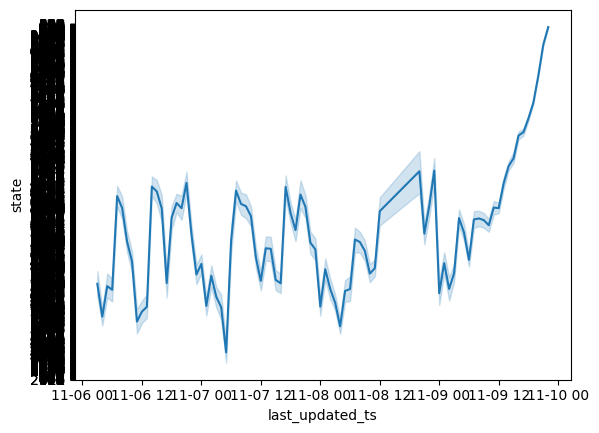

In [67]:
sns.lineplot(data=df, x='last_updated_ts', y='state')
plt.show()

In [69]:
import numpy as np
df['energy'] = np.trapz(y=df['state'], x=df['last_updated_ts'].astype(int)/1e9/3600)

/tmp/ipykernel_601/1643192142.py:2: DeprecationWarning: `trapz` is deprecated. Use `trapezoid` instead, or one of the numerical integration functions in `scipy.integrate`.
  df['energy'] = np.trapz(y=df['state'], x=df['last_updated_ts'].astype(int)/1e9/3600)


TypeError: can't multiply sequence by non-int of type 'float'